## Notebook libraries/Functions

In [1]:
import os
import gzip
import shutil
import glob
import random as rnd
from datetime import datetime, timezone

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import requests
from bs4 import BeautifulSoup

import h5py
import xarray as xr

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def get_path(parts):
    out_path = ""
    for part in parts:
        out_path = out_path + f"{part}{os.path.sep}"

    out_path = out_path.rstrip(os.path.sep)
    return out_path

## Download compressed HDF5 files, extract and delete Gzip files (if HDF5 files compressed with Gzip)

In [3]:
def download_files(url, root_dir, product, download_years, refresh=False):
    for yr in download_years:
        print(f"Downloading {product} files for {yr}")

        file_cnt = 0
        save_dir = get_path([root_dir, yr])

        html_page = f"{url}/{yr}"
        response = requests.get(html_page)
        try:
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                links = soup.find_all("a")

                for link in links:
                    href = link.get("href")

                    # Download file if it does not exist locally, or forced to refresh
                    if ".nc" in href:
                        # Create folder if files found to download
                        os.makedirs(save_dir, exist_ok=True)

                        download_url = f"{html_page}/{href}"

                        file_check = os.path.basename(download_url).replace(".gz", "")
                        if (
                            not os.path.exists(get_path([save_dir, file_check]))
                            or refresh == True
                        ):
                            file_cnt += 1
                            response = requests.get(download_url, stream=True)
                            response.raise_for_status()

                            file_name = get_path(
                                [save_dir, os.path.basename(download_url)]
                            )
                            with open(file_name, "wb") as file:
                                for chunk in response.iter_content(chunk_size=512):
                                    file.write(chunk)

        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")

        # Extract HDF5 files and delete .gz files
        files = os.listdir(save_dir)
        gz_files = [file for file in files if file.endswith(".gz")]

        for gz_file in gz_files:
            gz_file_path = get_path([save_dir, gz_file])
            hdf_file_path = os.path.splitext(gz_file_path)[0]

            if os.path.exists(hdf_file_path):
                os.remove(hdf_file_path)

            with gzip.open(gz_file_path, "rb") as comp_file:
                with open(hdf_file_path, "wb") as hdf_file:
                    shutil.copyfileobj(comp_file, hdf_file)

            os.remove(get_path([save_dir, gz_file]))

        print(
            f"Total downloaded and extracted {product} HDF5 files for {yr}: [{file_cnt}]"
        )

## Display 5 days for each year in two color schemes

In [4]:
def plot_selected_region(reduced_image_arrays, image_arrays, product):
    # Define subplot
    fig, axs = plt.subplots(2, 5, figsize=(16, 5))
    axs = axs.flatten()

    # First row
    colors_row1 = ["#000000", "#FFFFFF"]
    cmap_row1 = ListedColormap(
        colors_row1, name="custom_colormap_row_1", N=len(colors_row1)
    )

    sm_row1 = plt.cm.ScalarMappable(cmap=cmap_row1, norm=plt.Normalize(vmin=0, vmax=1))
    sm_row1.set_array([])

    for i, img_date in enumerate(reduced_image_arrays):
        axs[i].imshow(
            reduced_image_arrays[img_date],
            cmap=cmap_row1,
            vmin=0,
            vmax=len(colors_row1) - 1,
        )
        axs[i].set_title(img_date, fontsize=14)
        axs[i].axis("off")

    # Keep indexing for subplot
    offset = i + 1

    divider_row1 = make_axes_locatable(axs[len(reduced_image_arrays) - 1])
    cbar_ax_row1 = divider_row1.append_axes("right", size="10%", pad=0.1)
    #         cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar_row1 = plt.colorbar(
        sm_row1,
        cax=cbar_ax_row1,
        ticks=np.arange(len(colors_row1)),
        ax=axs.ravel().tolist(),
    )
    cbar_row1.ax.set_yticklabels(
        [
            "Not Sea Ice",
            "Sea Ice",
        ],
        fontsize=14,
    )
    cbar_row1.set_label("Surface Types", fontsize=16)

    # Second row
    """
    Define a custom colormap with five colors
    0 (outside Northern Hemisphere)
    1 (open water)
    2 (land without snow)
    3 (sea or lake ice)
    4 (snow covered land)
    """
    colors_row2 = ["#E500E5", "#0066FF", "#01FF00", "#FFC100", "#E50000"]
    cmap_row2 = ListedColormap(
        colors_row2, name="custom_colormap_row_2", N=len(colors_row2)
    )

    sm_row2 = plt.cm.ScalarMappable(cmap=cmap_row2, norm=plt.Normalize(vmin=0, vmax=1))
    sm_row2.set_array([])

    for i, img_date in enumerate(image_arrays):
        axs[i + offset].imshow(
            image_arrays[img_date],
            cmap=cmap_row2,
            vmin=0,
            vmax=len(colors_row2) - 1,
        )
        axs[i + offset].set_title(img_date, fontsize=14)
        axs[i + offset].axis("off")

    divider_row2 = make_axes_locatable(axs[len(image_arrays) - 1 + offset])
    cbar_ax_row2 = divider_row2.append_axes("right", size="10%", pad=0.1)
    cbar_row2 = plt.colorbar(sm_row2, cax=cbar_ax_row2)
    cbar_row2.ax.set_yticklabels(
        [
            "Outside Northern Hemisphere",
            "Open Water",
            "Land without Snow",
            "Sea or Lake Ice",
            "Snow Covered Land",
        ],
        fontsize=16,
    )
    cbar_row2.set_label("Surface Types", fontsize=16)

    yr = img_date[0:4]
    plt.suptitle(f"{product} for {yr}", y=1, fontsize=18)
    plt.show()

In [5]:
def display_examples(root_dir, analysis_years, product, dataset_name):
    rnd.seed(31415)

    for yr in analysis_years:
        image_arrays = {}
        reduced_image_arrays = {}
        hdf5_dir = get_path([root_dir, yr])
        file_list = glob.glob(get_path([hdf5_dir, "*.nc"]))

        # Pick 10 random files
        random_list = rnd.sample(file_list, 5)

        for i, hdf5_file in enumerate(random_list):
            ds = xr.open_dataset(hdf5_file)

            # Time stamp
            dt64 = ds["time"][0].values
            formatted_date = np.datetime_as_string(dt64, unit="D")

            sie = ds[dataset_name]

            ds.close()

            sie = np.rot90(sie, 2)

            array_2D = sie[0, :, :]

            # Define longitude and latitude bounds
            # Greenland-ish
            #         min_lon, max_lon = 6.0, 35.0
            #         min_lat, max_lat = 45.0, 55.0
            # Wikipedia long/lat
            #         min_lon, max_lon = 124.08, 127.32
            #         min_lat, max_lat = 70.36, 76.16

            min_lon, max_lon = -60.0, -12.5
            min_lat, max_lat = 45.0, 52.5

            # Get the longitude values corresponding to the data array
            lon_values = np.linspace(-180.0, 180.0, array_2D.shape[1], endpoint=False)

            # Find the indices corresponding to the specified longitude bounds
            lon_indices = np.where((lon_values >= min_lon) & (lon_values <= max_lon))[0]

            lat_values = np.linspace(0.0, 90.0, array_2D.shape[0], endpoint=False)

            # Find the indices corresponding to the specified latitude bounds
            lat_indices = np.where((lat_values >= min_lat) & (lat_values <= max_lat))[0]

            # Select the subset of the data array based on both longitude and latitude bounds
            subset_data_array = array_2D[lat_indices][:, lon_indices]
            subset_data_array2 = array_2D[lat_indices][:, lon_indices]

            # Updates arrays and set dictionary values
            if product == "MICROWAVE":
                """
                + Set all values to < 1 = 0
                + Set all values < 1 and > 2 = 1
                + Set all values > 2 = 2
                """
                data_values = array_2D[lat_indices][:, lon_indices]
                subset_data_array = np.zeros_like(data_values)
                subset_data_array[data_values <= 0.33] = 0
                subset_data_array[(data_values > 0.33) & (data_values < 0.66)] = 1
                subset_data_array[data_values >= 0.66] = 2

                image_arrays[formatted_date] = subset_data_array

                """
                ONLY APPLY FOR BLACK-AND-WHITE PLOTS
                + Set all non-1 values to 0
                + Set all 1 values to 1
                """
                subset_data_array2[subset_data_array2 != 1] = 0
                subset_data_array2[subset_data_array2 == 1] = 1

                reduced_image_arrays[formatted_date] = subset_data_array2

            else:
                image_arrays[formatted_date] = subset_data_array

                """
                ONLY APPLY FOR BLACK-AND-WHITE PLOTS
                + Set all all non-3 values to 0
                + Set all 3 values to 1
                """
                subset_data_array2[subset_data_array2 != 3] = 0
                subset_data_array2[subset_data_array2 == 3] = 1

                reduced_image_arrays[formatted_date] = subset_data_array2

        # Sort by date ascending
        image_arrays = dict(sorted(image_arrays.items()))
        reduced_image_arrays = dict(sorted(reduced_image_arrays.items()))

        plot_selected_region(reduced_image_arrays, image_arrays, product)

        # Clear memory
        image_arrays = None
        reduced_image_arrays = None

# Define each product, download and show examples

Total downloaded and extracted IMS HDF5 files for 2015: [0]
Total downloaded and extracted IMS HDF5 files for 2016: [0]
Total downloaded and extracted IMS HDF5 files for 2017: [0]
Total downloaded and extracted IMS HDF5 files for 2018: [0]
Total downloaded and extracted IMS HDF5 files for 2019: [0]
Total downloaded and extracted IMS HDF5 files for 2020: [0]
Total downloaded and extracted IMS HDF5 files for 2021: [0]
Total downloaded and extracted IMS HDF5 files for 2022: [0]
Total downloaded and extracted IMS HDF5 files for 2023: [0]
Total downloaded and extracted IMS HDF5 files for 2024: [1]
Preparing sample images...


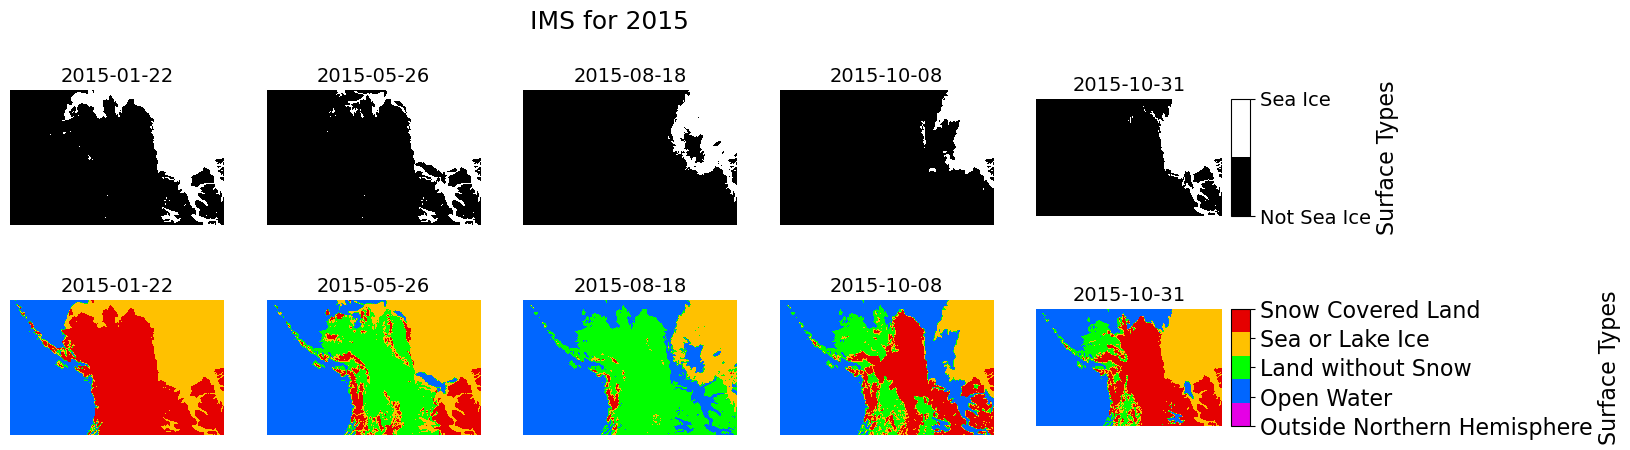

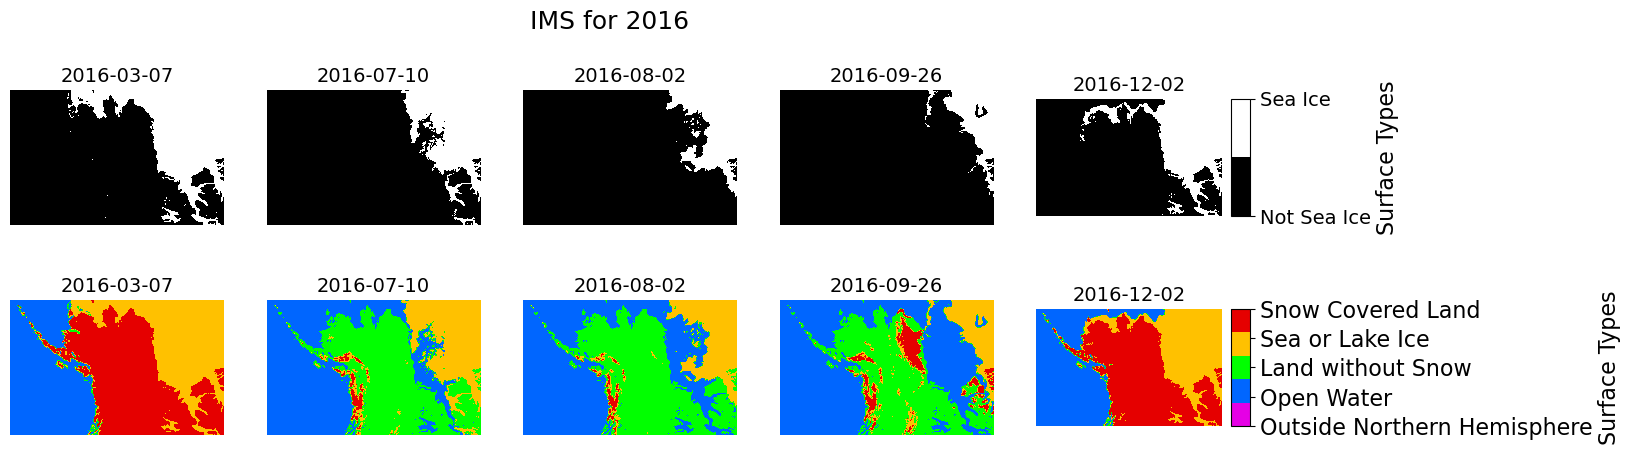

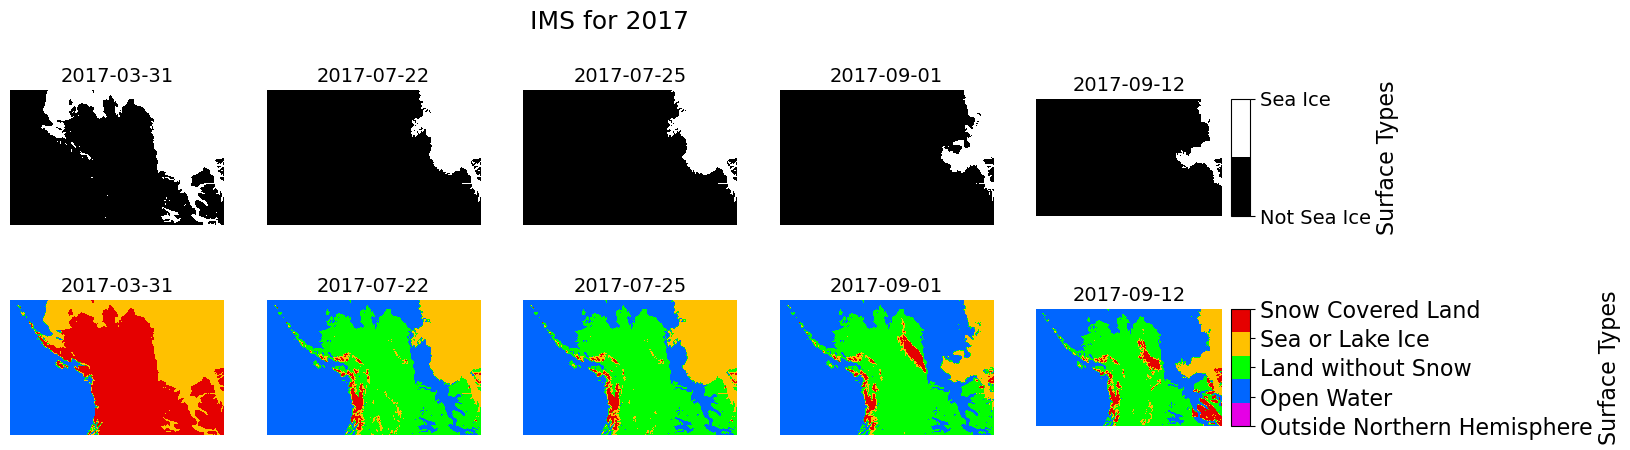

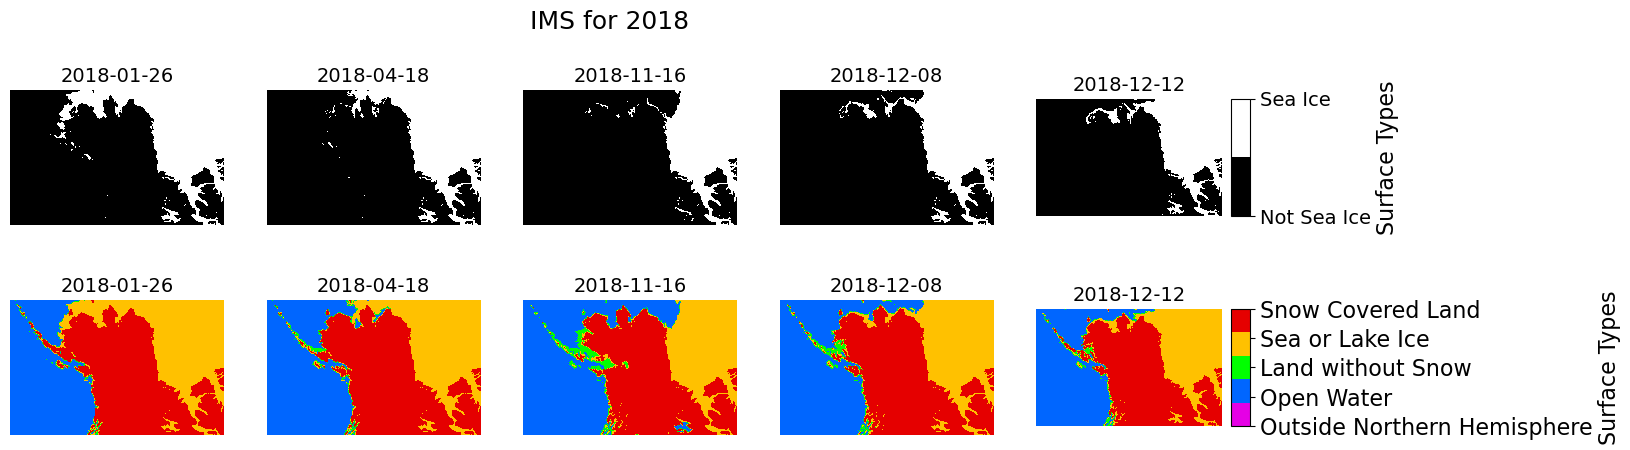

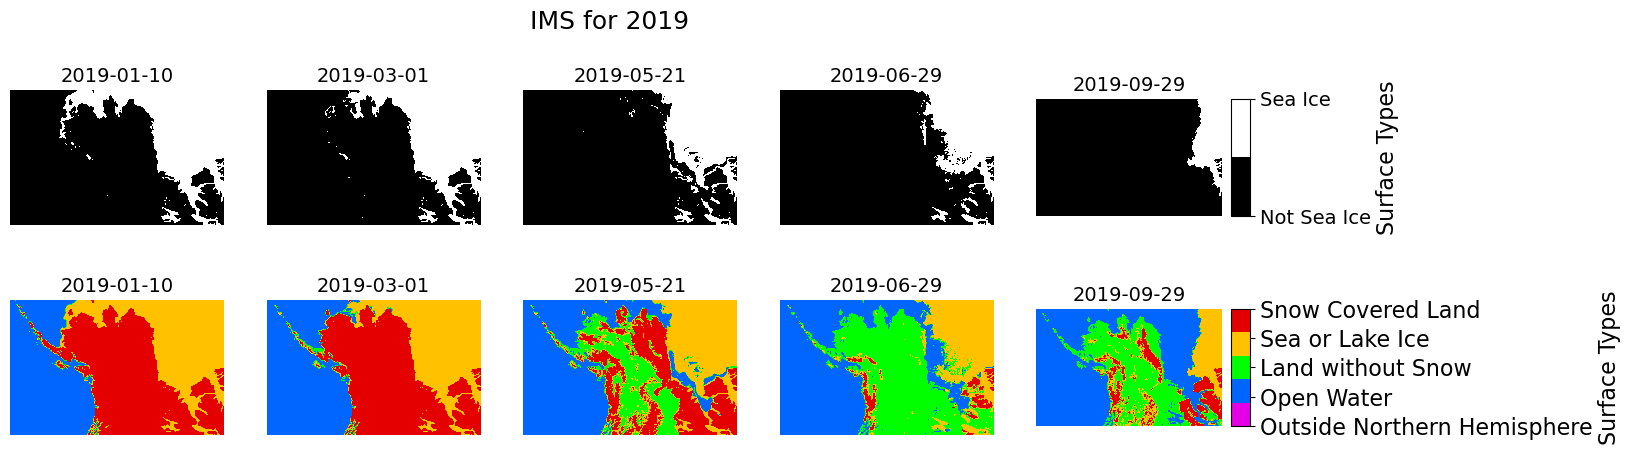

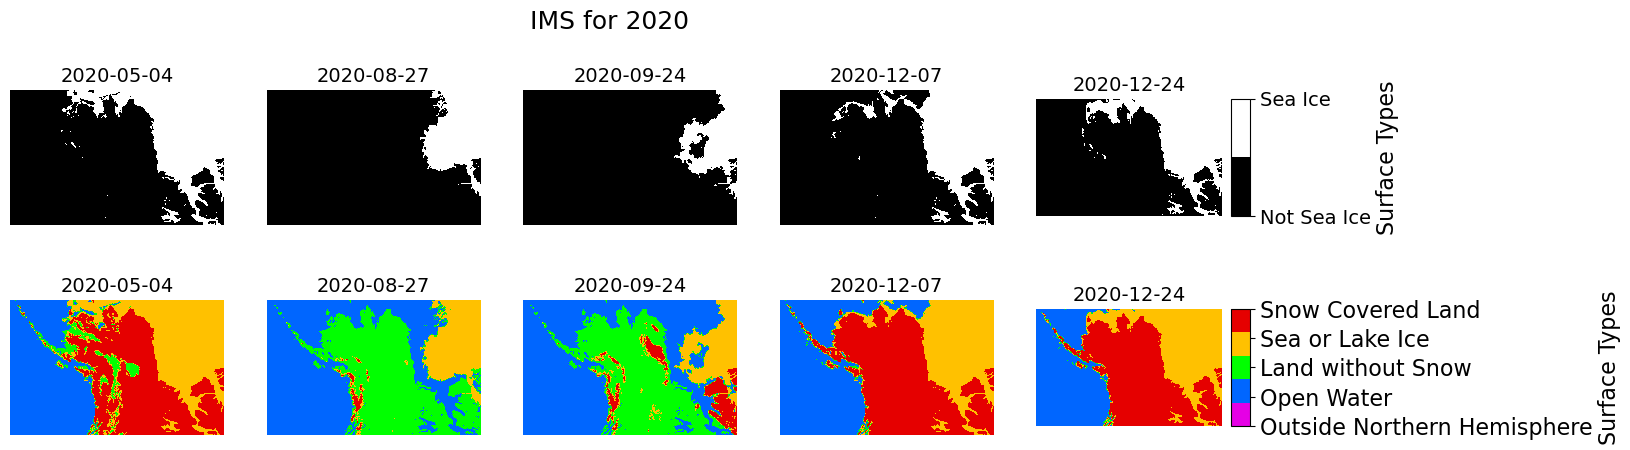

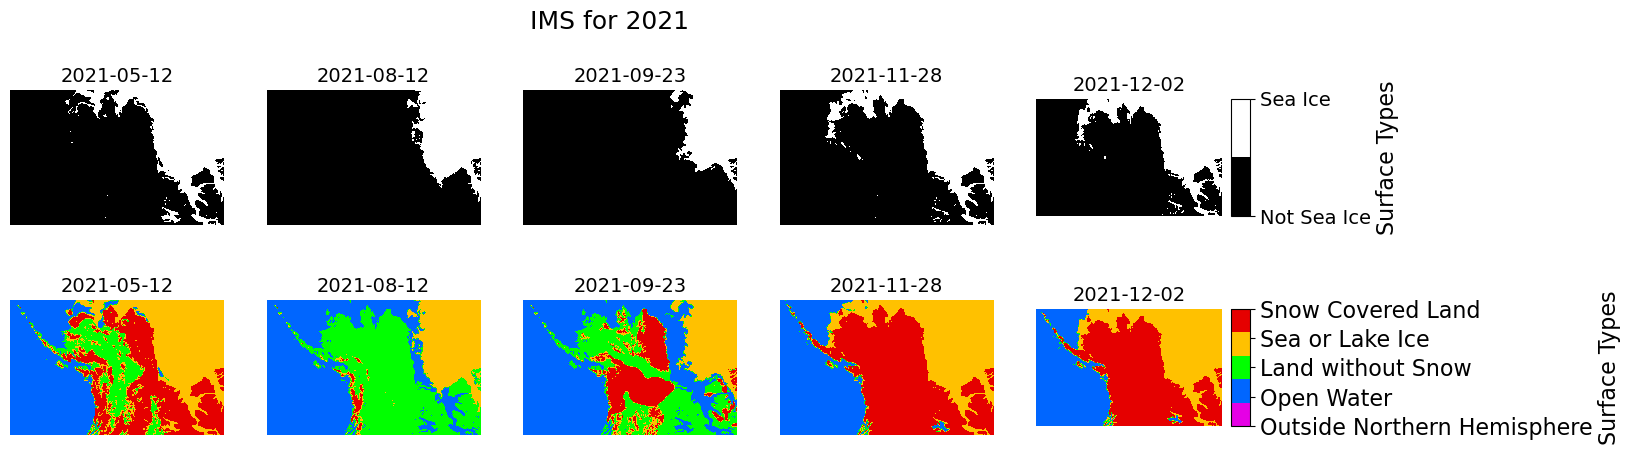

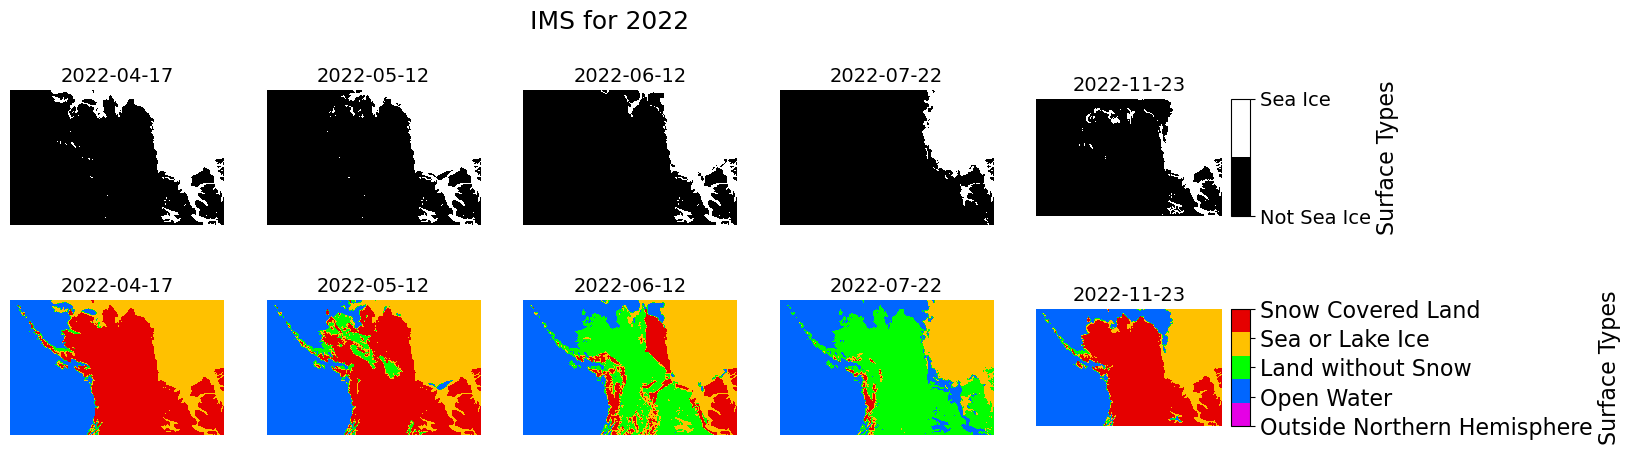

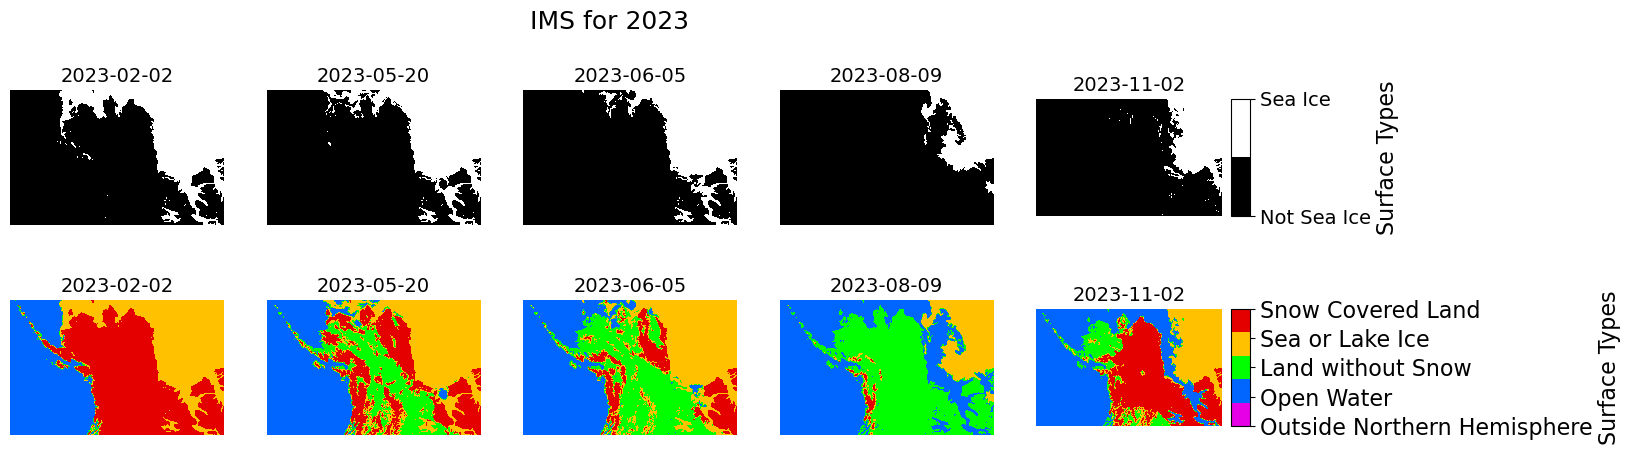

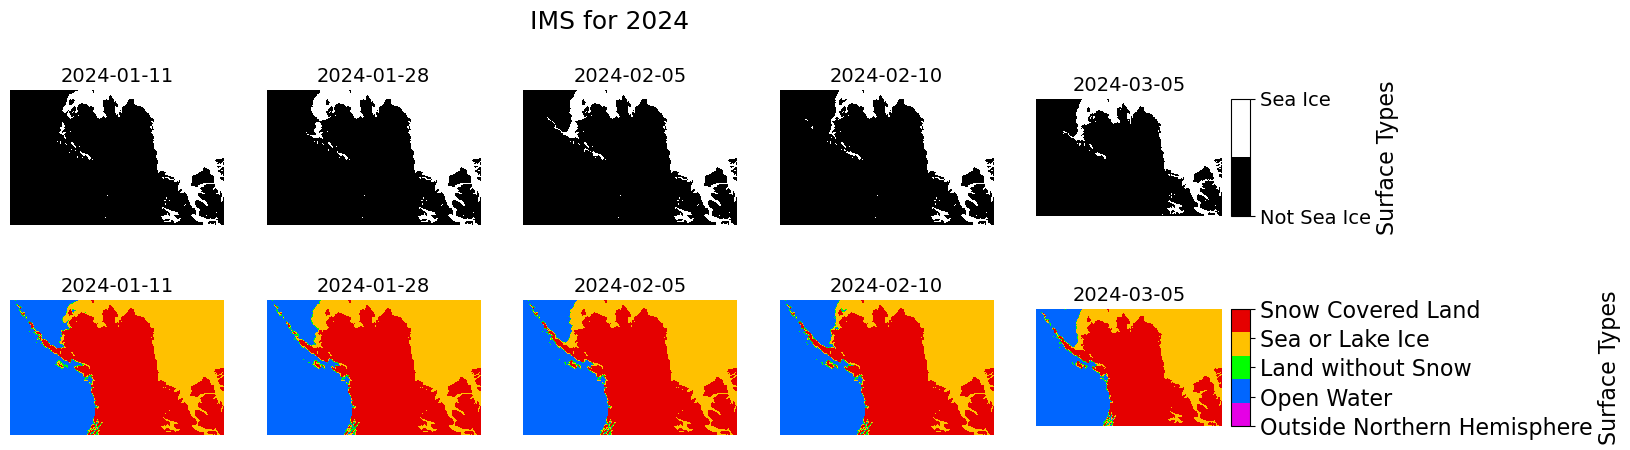

Total downloaded and extracted MASIE HDF5 files for 2015: [0]
Total downloaded and extracted MASIE HDF5 files for 2016: [0]
Total downloaded and extracted MASIE HDF5 files for 2017: [0]
Total downloaded and extracted MASIE HDF5 files for 2018: [0]
Total downloaded and extracted MASIE HDF5 files for 2019: [0]
Total downloaded and extracted MASIE HDF5 files for 2020: [0]
Total downloaded and extracted MASIE HDF5 files for 2021: [0]
Total downloaded and extracted MASIE HDF5 files for 2022: [0]
Total downloaded and extracted MASIE HDF5 files for 2023: [0]
Total downloaded and extracted MASIE HDF5 files for 2024: [0]
Preparing sample images...


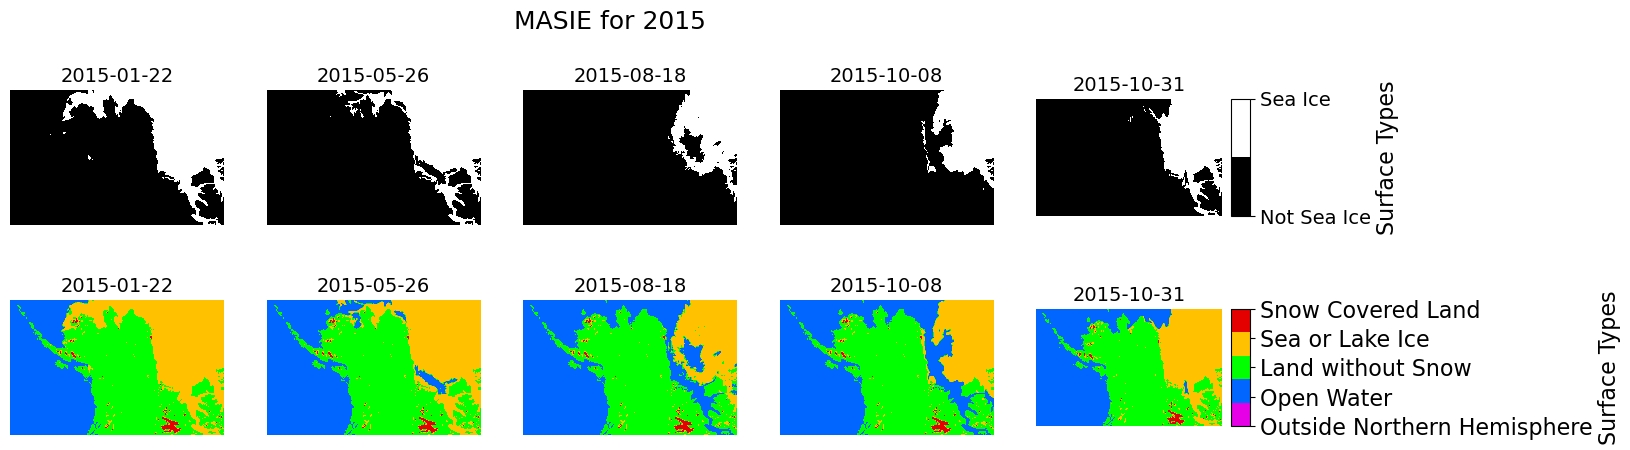

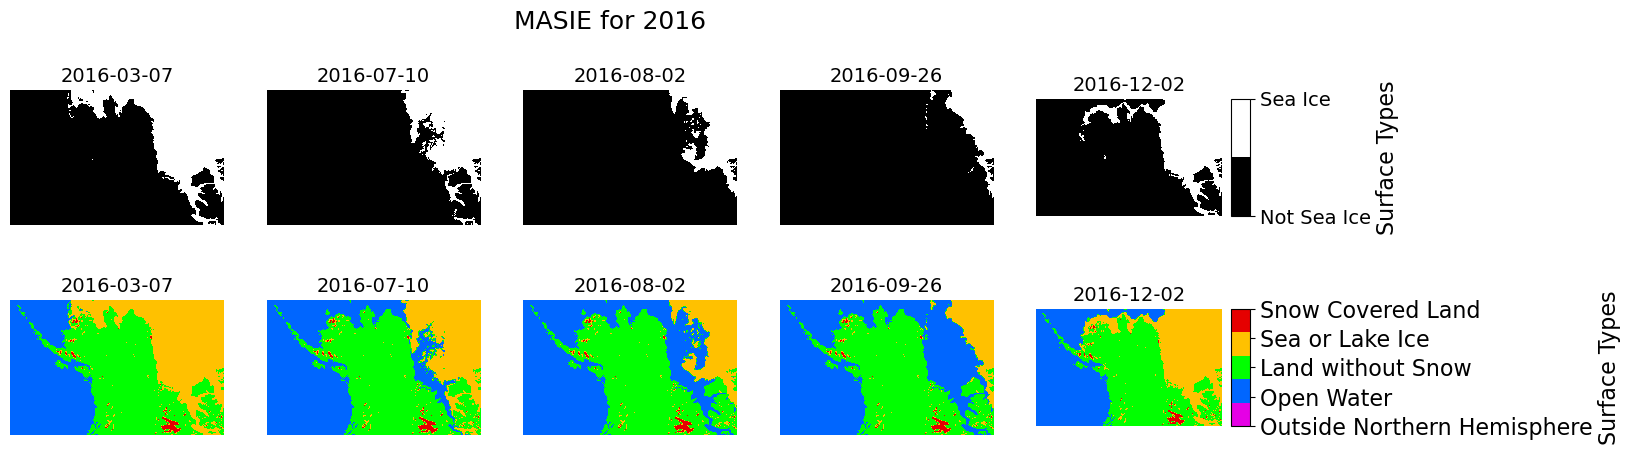

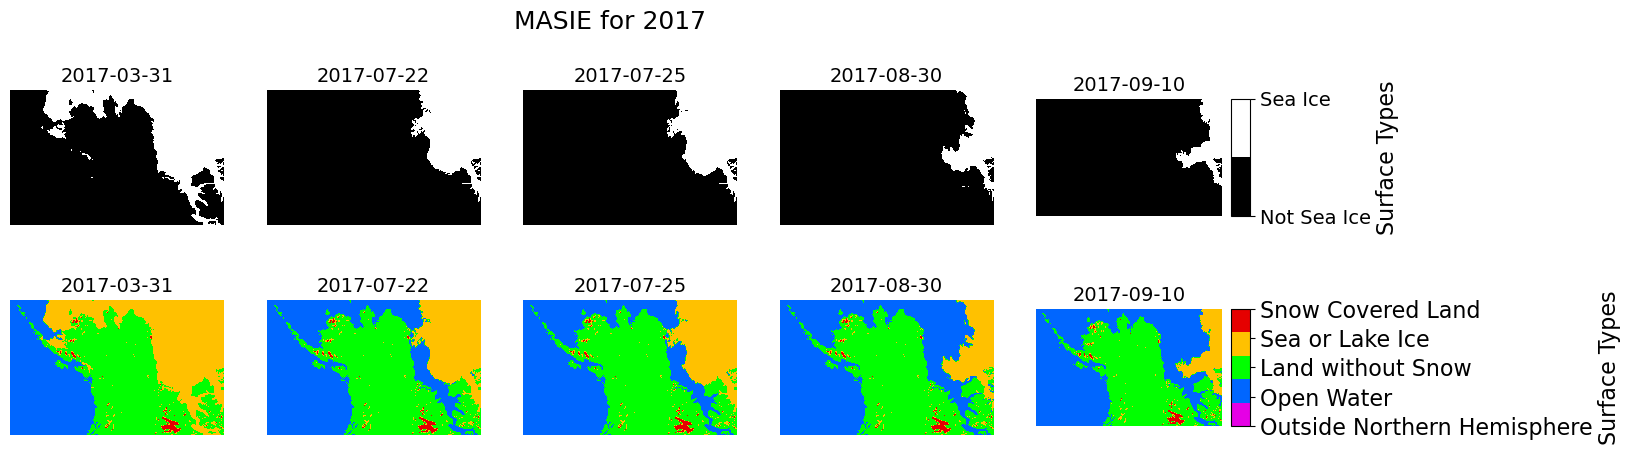

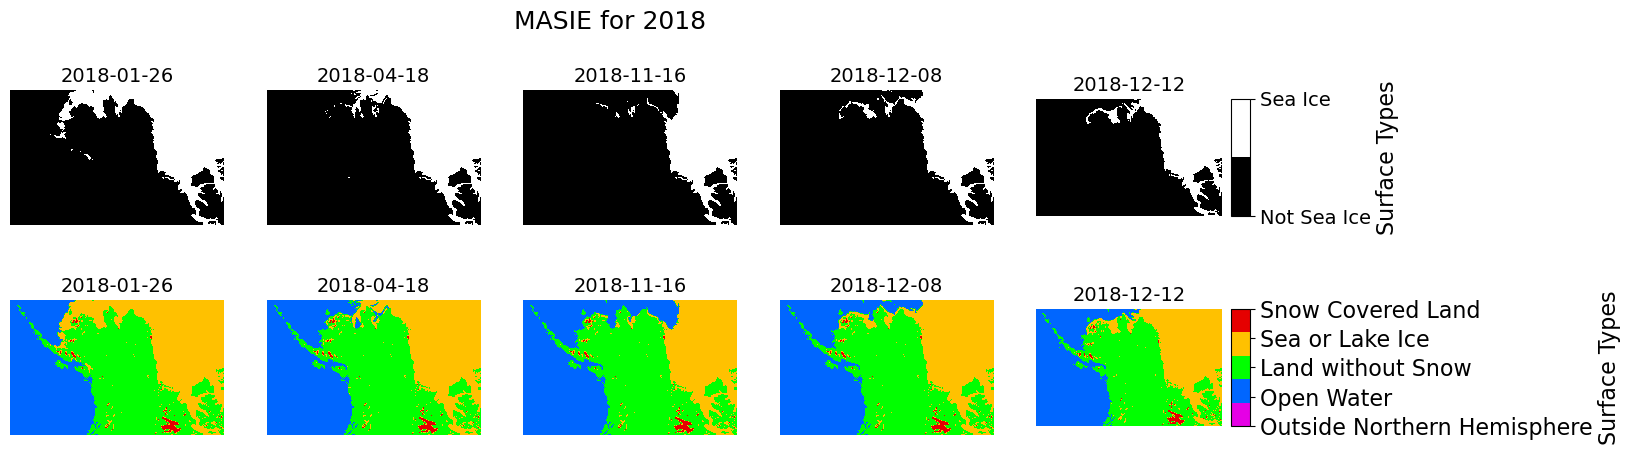

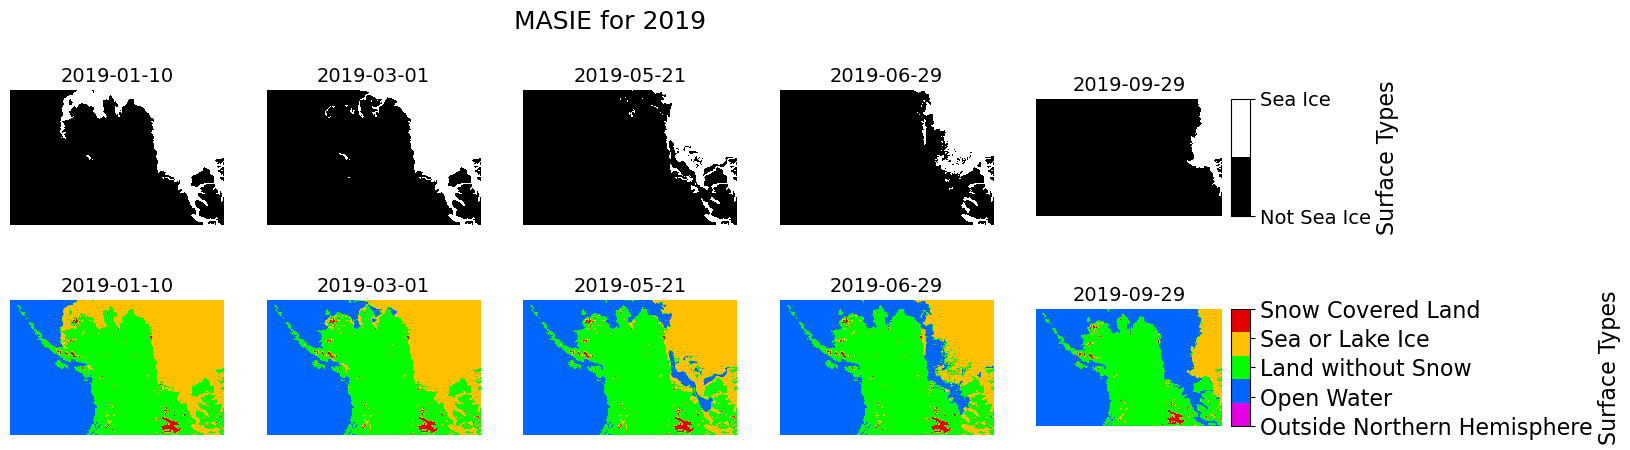

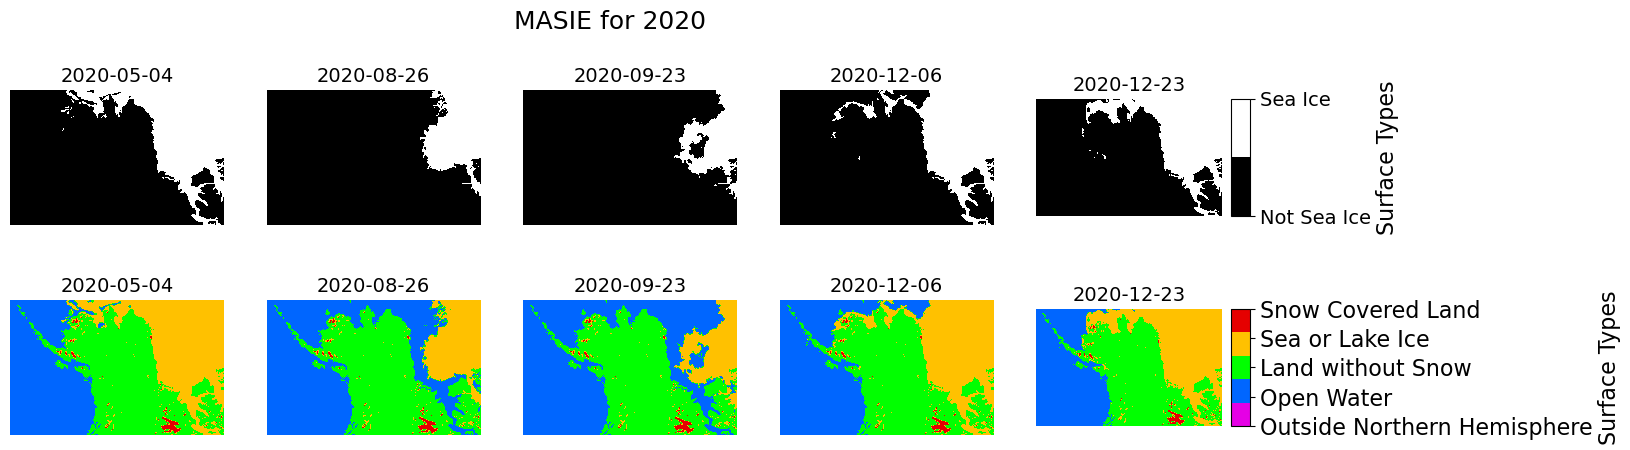

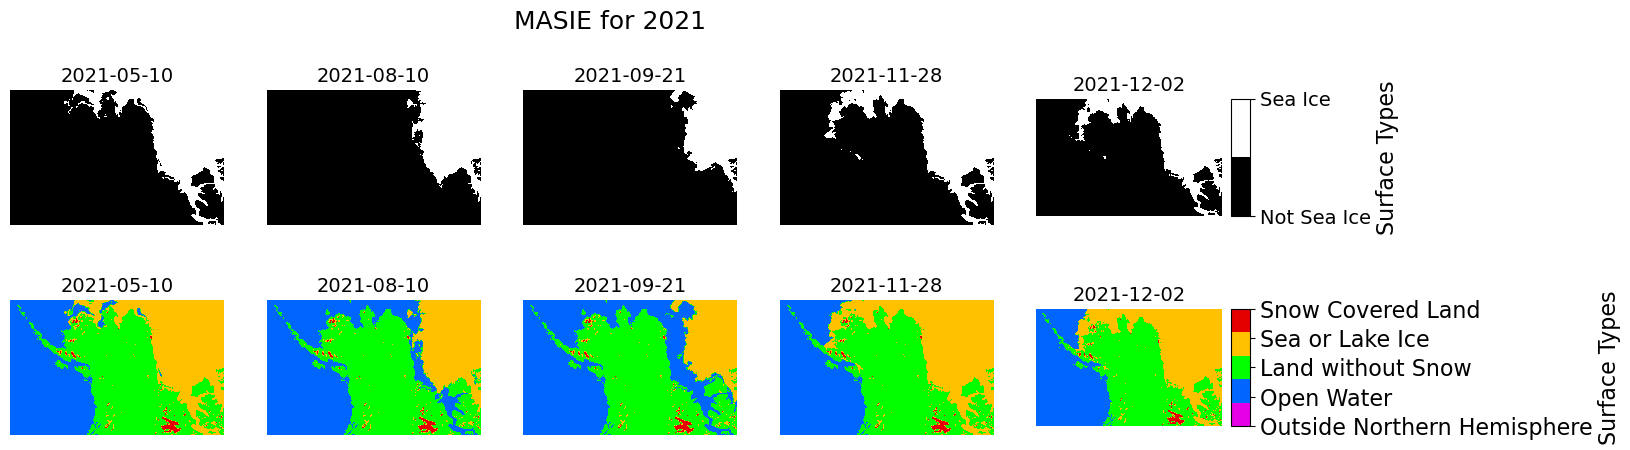

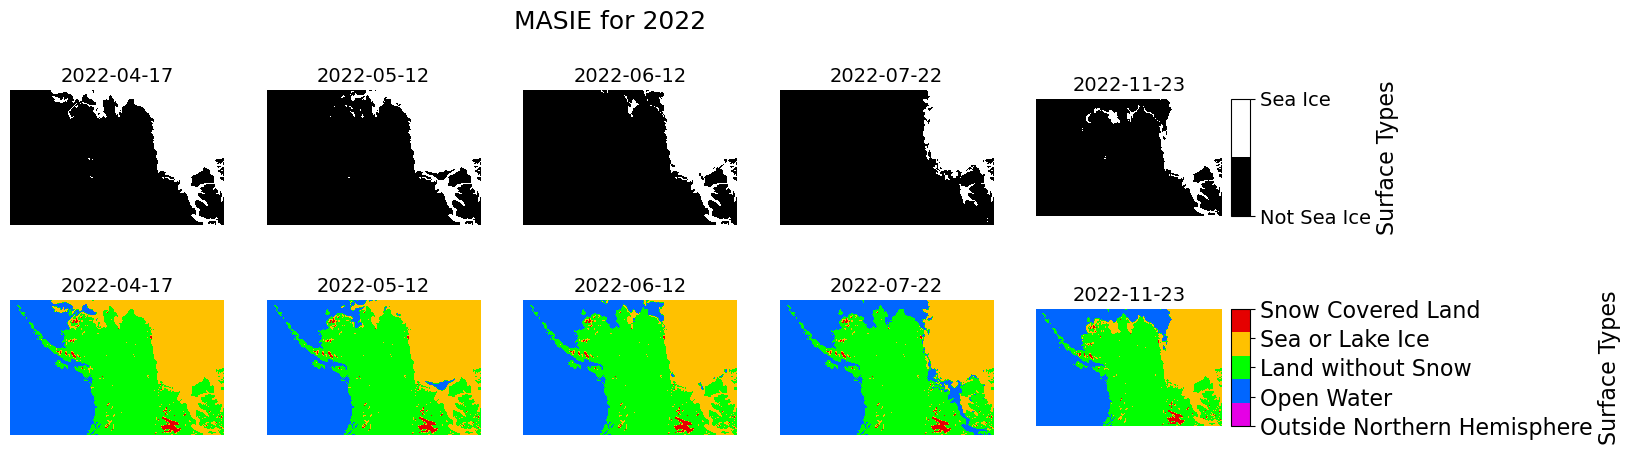

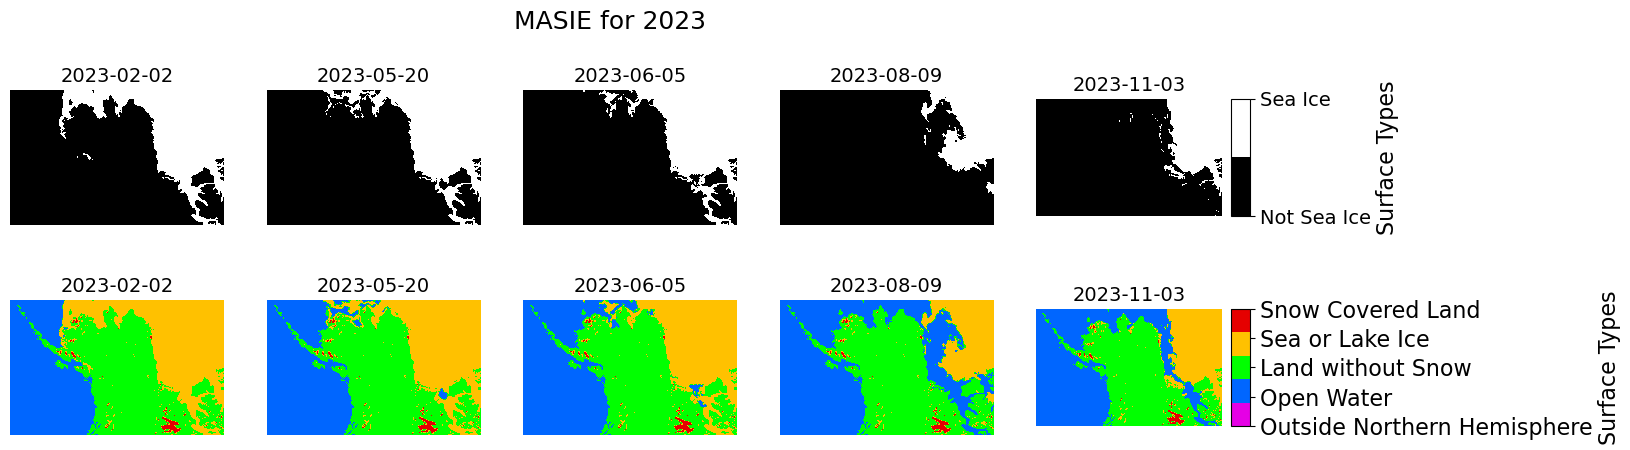

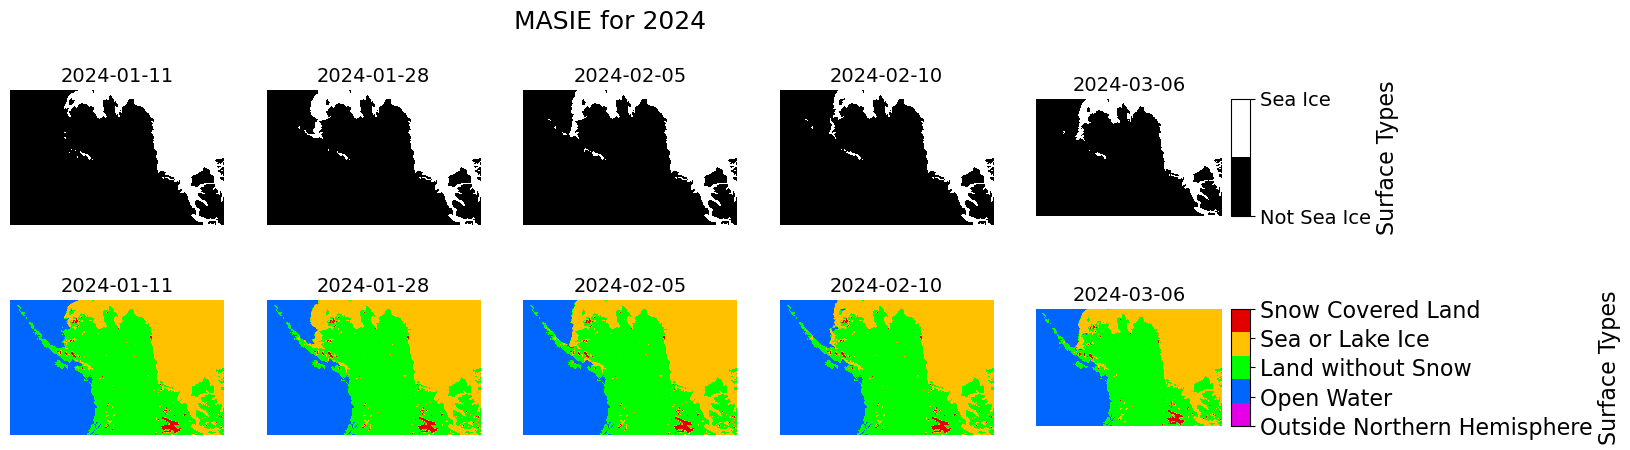

In [6]:
"""
Define year range:
    - download_years: 
        + years downloaded for each product
        + change date range to only get current data, e.g. range(2024, 2025)
        + set to None to just see samples of locally stored data
    - analysis_years:
        + years to process and plot       
Define root directory where the files will be saved for each product
Define products to be downloaded with URL

* To update locally stored files, set refresh=True in download_files()
* When refresh=False, files on the web server will not be downloaded if the file exists locally
"""
download_years = range(2015, 2025)
analysis_years = range(2015, 2025)

root_dir = get_path(["D:", "IceDyno"])
products = {}
datasets = {}
products["IMS"] = "https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/1km"
products["MASIE"] = "https://noaadata.apps.nsidc.org/NOAA/G02186/netcdf/1km"
datasets["IMS"] = "IMS_Surface_Values"
datasets["MASIE"] = "sea_ice_extent"

for product in products:
    # Set product directory
    product_dir = get_path([root_dir, f"{product}_images"])

    # Download files for product
    if download_years != None:
        download_files(products[product], product_dir, product, download_years)

    # Show examples of each product (5 days in two color schemes for each year)
    print("Preparing sample images...")
    display_examples(product_dir, analysis_years, product, datasets[product])